# Data Analysis

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [14]:
# Load dataset
df = pd.read_csv('dataset_full.csv')

# Display general information
print("Dataset Overview:")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print("\nMissing Values:")
print(df.isnull().sum().sum())

Dataset Overview:
Number of samples: 88647
Number of features: 112

Missing Values:
0


In [15]:
# Remove duplicates
initial_rows = df.shape[0]
df = df.drop_duplicates()
duplicates_removed = initial_rows - df.shape[0]
print(f"\nDuplicates removed: {duplicates_removed}")

# Remove constant columns
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
df = df.drop(columns=constant_columns)
print(f"Constant columns removed: {len(constant_columns)}")


Duplicates removed: 1438
Constant columns removed: 13


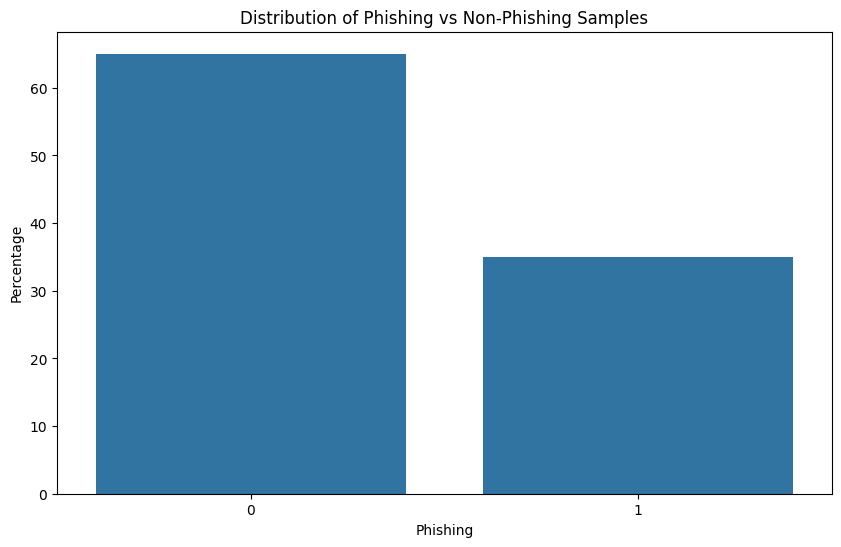


Class Distribution:
phishing
0    65.029985
1    34.970015
Name: proportion, dtype: float64


In [16]:
# Class Distribution Analysis
plt.figure(figsize=(10, 6))
class_dist = df['phishing'].value_counts(normalize=True) * 100
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Distribution of Phishing vs Non-Phishing Samples')
plt.xlabel('Phishing')
plt.ylabel('Percentage')
plt.show()

print("\nClass Distribution:")
print(class_dist)

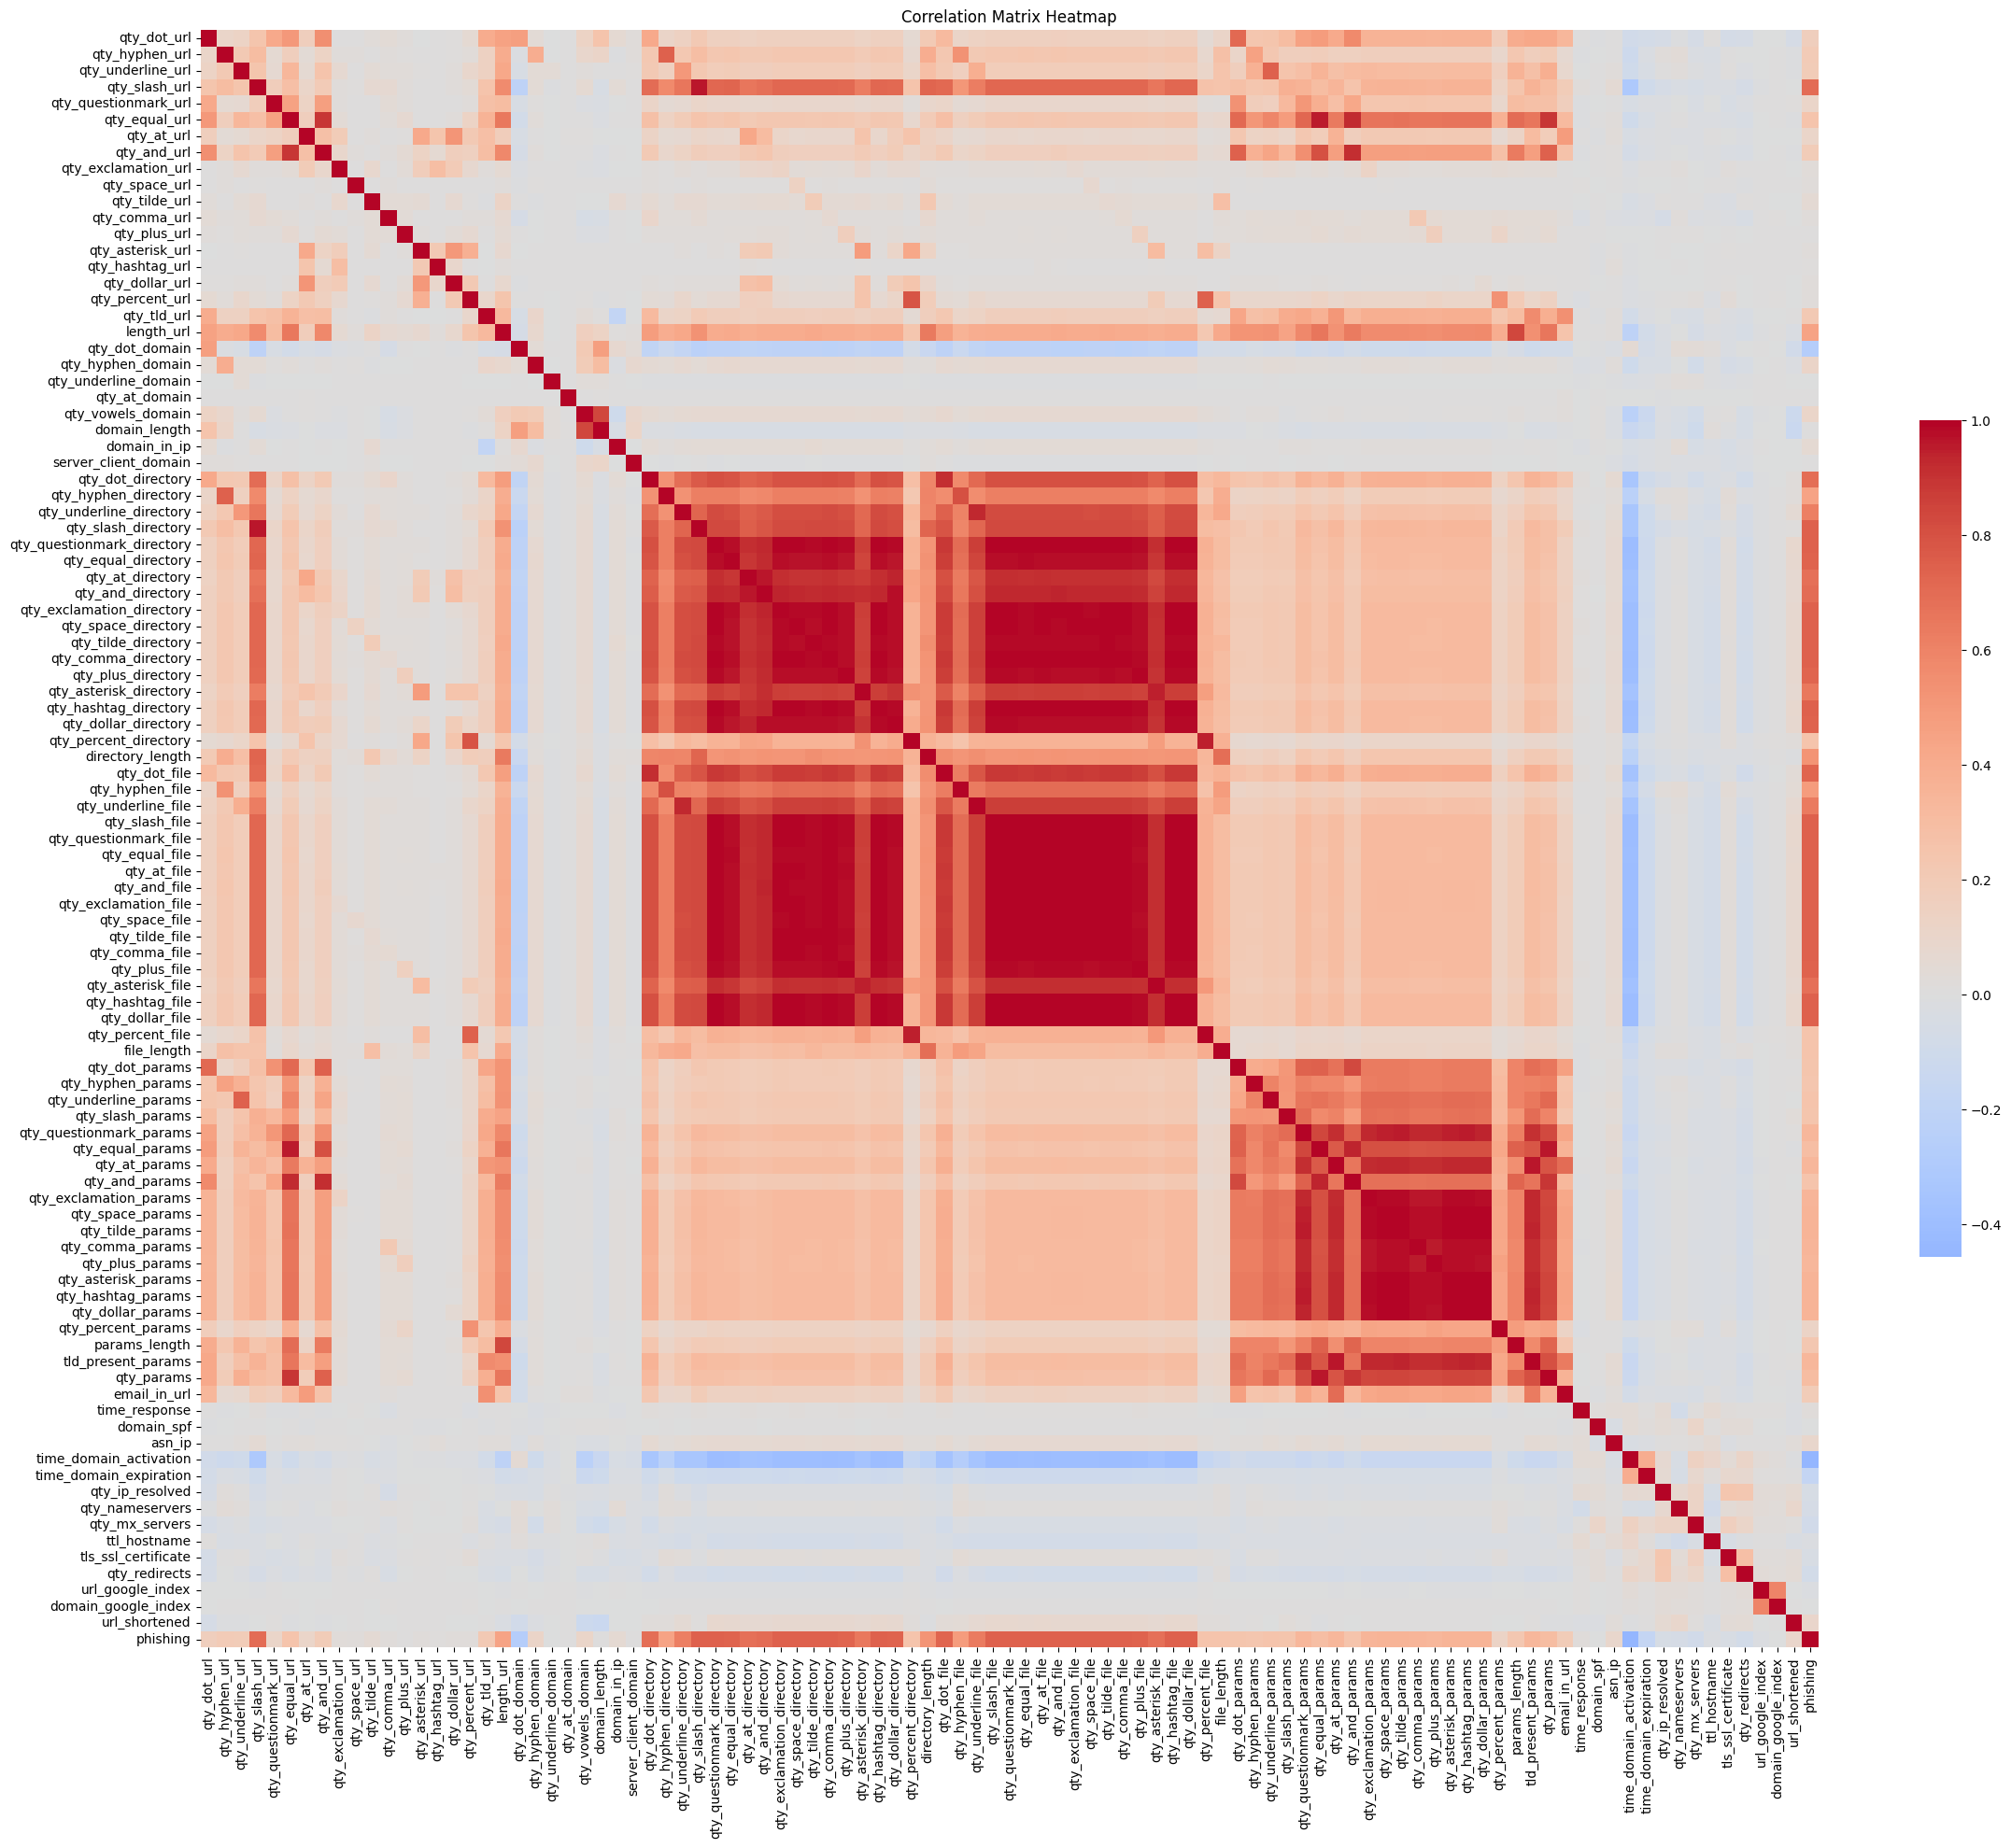

In [5]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Set figure size based on the number of features
plt.figure(figsize=(24, 20))

# Plot heatmap without annotations for readability
sns.heatmap(correlation_matrix,
            cmap='coolwarm',
            center=0,
            annot=False,
            square=True,
            cbar_kws={'shrink': 0.5})

plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [17]:
# Separate features (X) and target variable (y)
X = df.drop('phishing', axis=1)
y = df['phishing']

# Feature Selection using Mutual Information
k_best = SelectKBest(score_func=mutual_info_classif, k=30)
X_selected = k_best.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[k_best.get_support()].tolist()
print("Selected features:", selected_features)


Selected features: ['qty_slash_url', 'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'qty_questionmark_directory', 'qty_equal_directory', 'qty_at_directory', 'qty_and_directory', 'qty_exclamation_directory', 'qty_space_directory', 'qty_comma_directory', 'qty_asterisk_directory', 'qty_hashtag_directory', 'directory_length', 'qty_dot_file', 'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file', 'qty_questionmark_file', 'qty_equal_file', 'qty_at_file', 'qty_exclamation_file', 'qty_space_file', 'qty_tilde_file', 'qty_plus_file', 'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file', 'file_length']


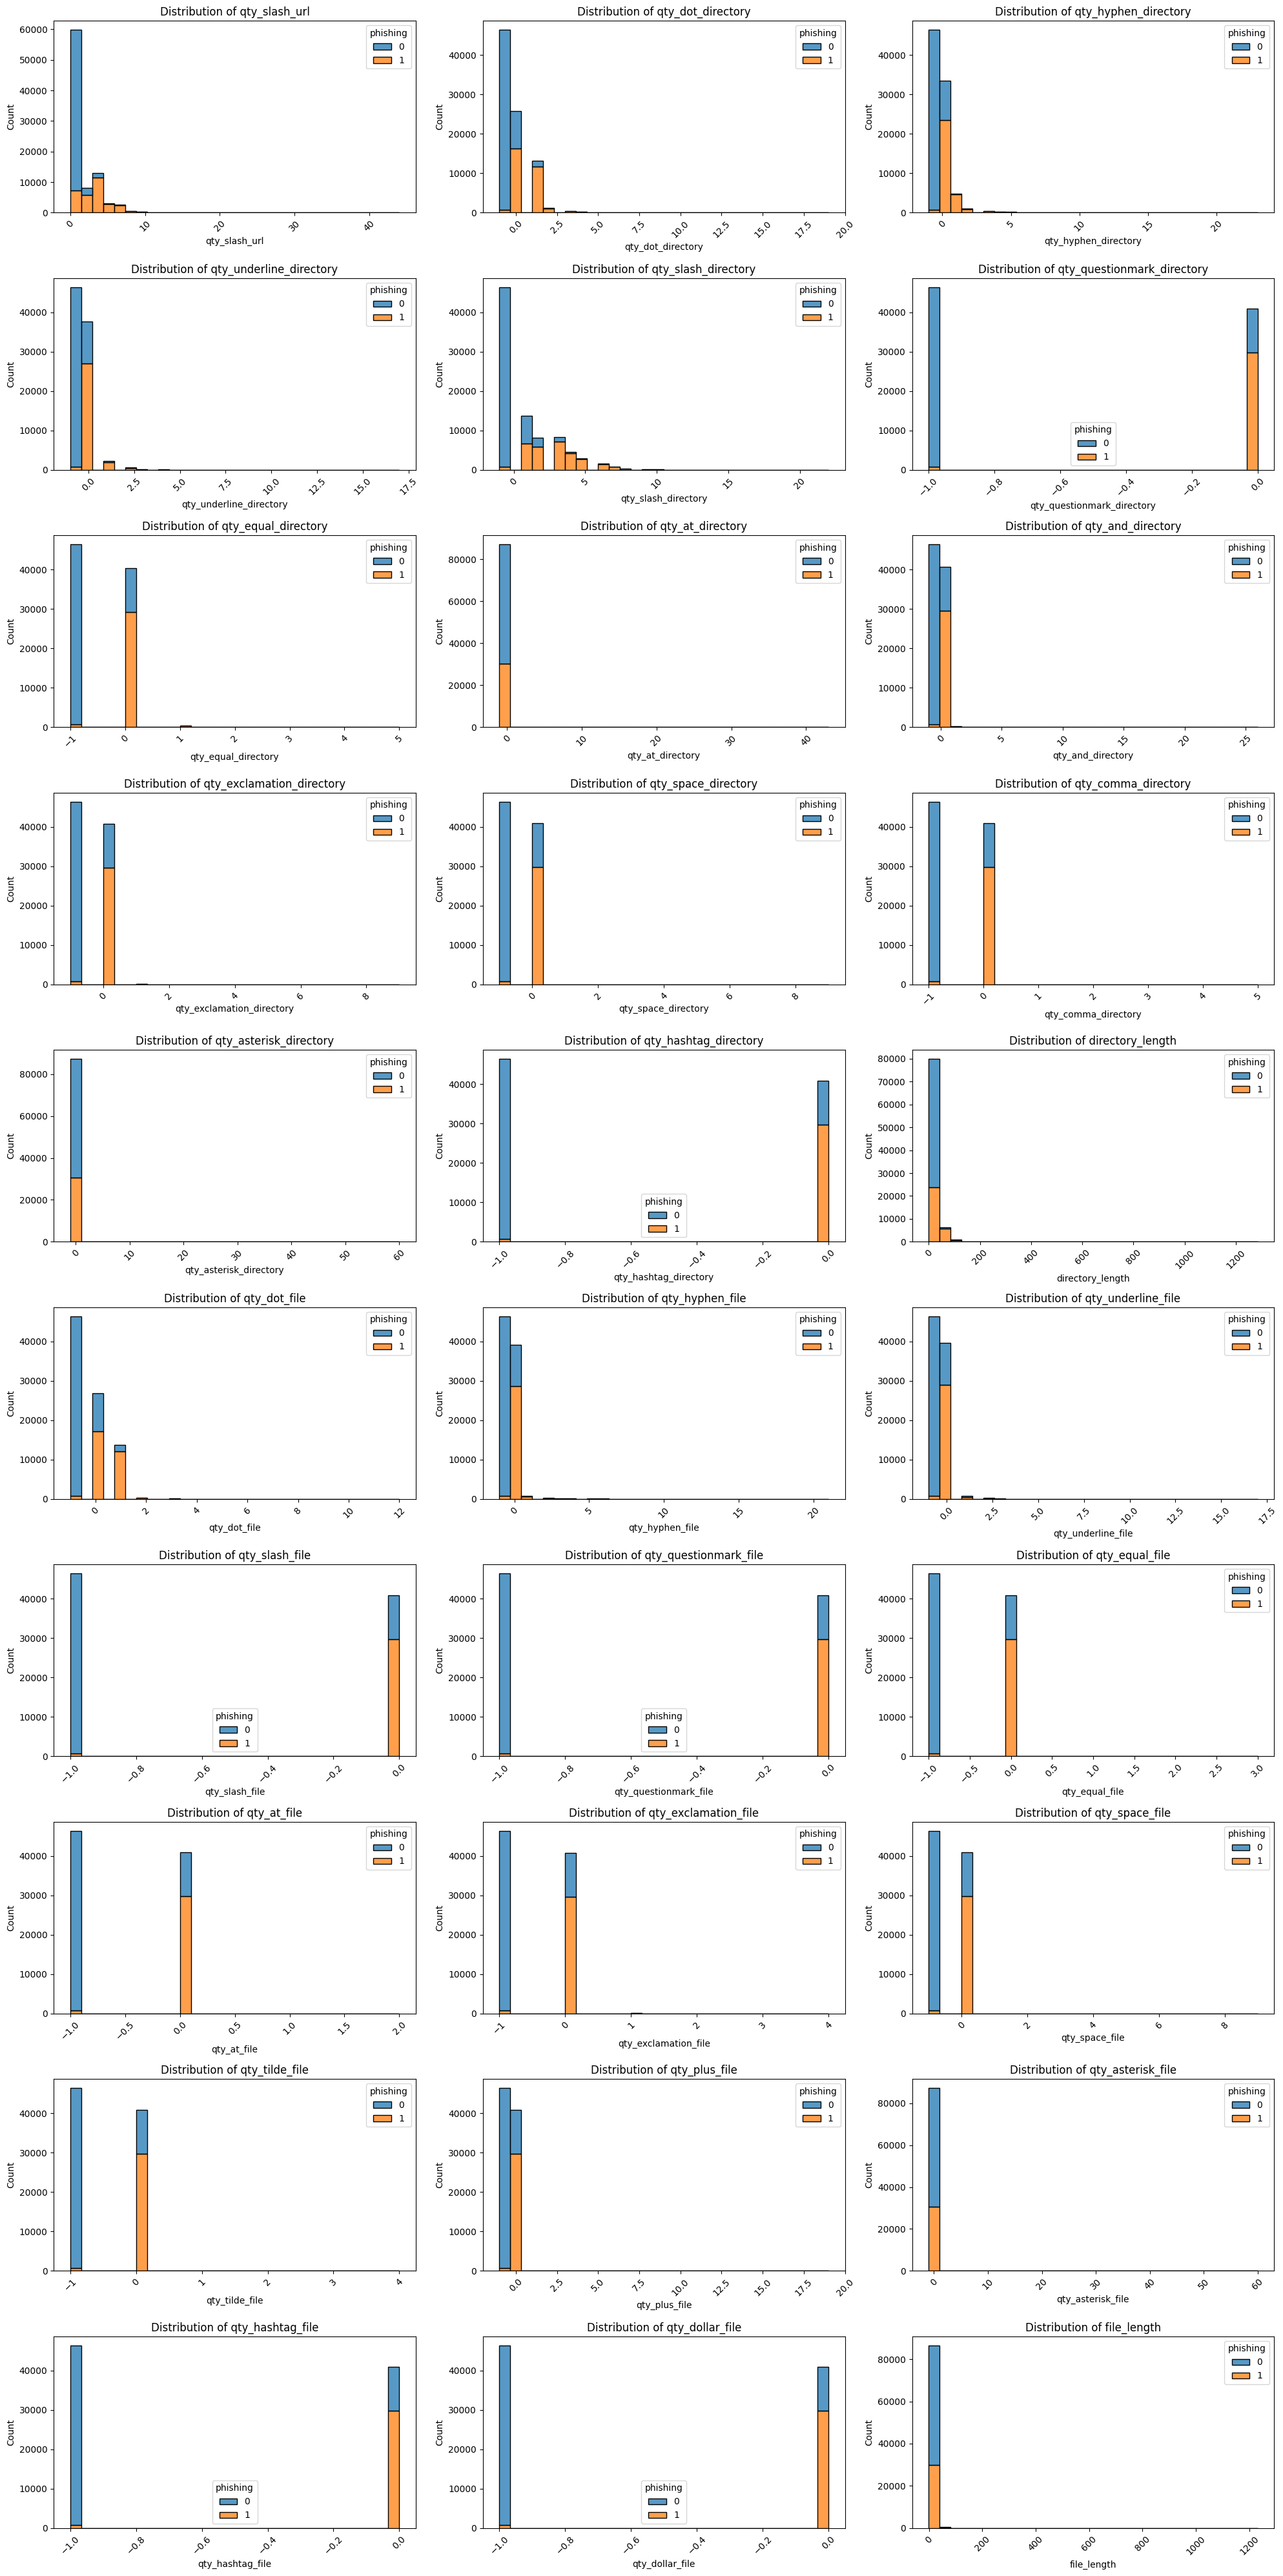


Summary Statistics for Selected Features:
       qty_slash_url  qty_dot_directory  qty_hyphen_directory  \
count   87209.000000       87209.000000          87209.000000   
mean        1.292688          -0.316917             -0.354172   
std         1.896041           0.901277              1.106610   
min         0.000000          -1.000000             -1.000000   
25%         0.000000          -1.000000             -1.000000   
50%         0.000000          -1.000000             -1.000000   
75%         2.000000           0.000000              0.000000   
max        44.000000          19.000000             23.000000   

       qty_underline_directory  qty_slash_directory  \
count             87209.000000         87209.000000   
mean                 -0.472463             0.729260   
std                   0.684480             2.217893   
min                  -1.000000            -1.000000   
25%                  -1.000000            -1.000000   
50%                  -1.000000           

In [18]:
# Create distribution plots for selected features
plt.figure(figsize=(20, 40))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(10, 3, i)
    sns.histplot(data=df, x=feature, hue='phishing', multiple="stack", bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics for each feature
print("\nSummary Statistics for Selected Features:")
print(df[selected_features].describe())

# Calculate and print the mean values for phishing vs non-phishing
print("\nMean values by class:")
print(df.groupby('phishing')[selected_features].mean())

In [7]:
# Update X with selected features
X = X[selected_features]

#To split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#To scale matrix of features
scaled_X = StandardScaler()
X_train = scaled_X.fit_transform(X_train)
X_test = scaled_X.transform(X_test)

# Random Forest Model

In [8]:
# Random Forest with GridSearch and Cross-validation
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=0),
    rf_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

print("Best Random Forest parameters:", rf_grid.best_params_)
rf_classifier = rf_grid.best_estimator_

Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


# KNN Model

In [9]:
# KNN with GridSearch
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for manhattan_distance, 2 for euclidean_distance
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
knn_grid.fit(X_train, y_train)

print("Best KNN parameters:", knn_grid.best_params_)
knn_classifier = knn_grid.best_estimator_

Best KNN parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


# Gradient Boosting Model

In [10]:
# Gradient Boosting Classifier
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=0),
    gb_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
gb_grid.fit(X_train, y_train)

print("Best Gradient Boosting parameters:", gb_grid.best_params_)
gb_classifier = gb_grid.best_estimator_

Best Gradient Boosting parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


# Naive Bayes Model

In [11]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

# Evaluate with cross-validation


Random Forest Cross-validation scores:
F1 Score: 0.864 (+/- 0.005)
Accuracy: 0.904 (+/- 0.003)
Precision: 0.857 (+/- 0.008)
Recall: 0.870 (+/- 0.007)


<Figure size 800x600 with 0 Axes>

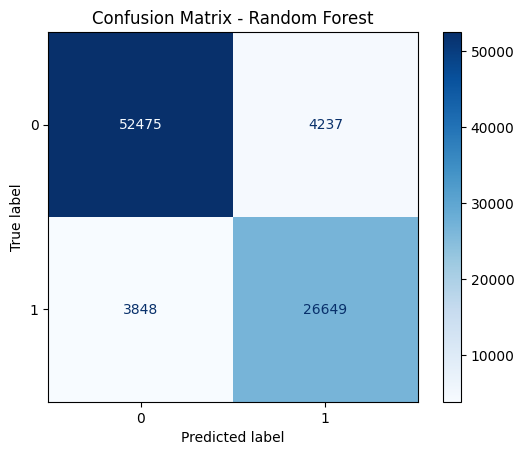

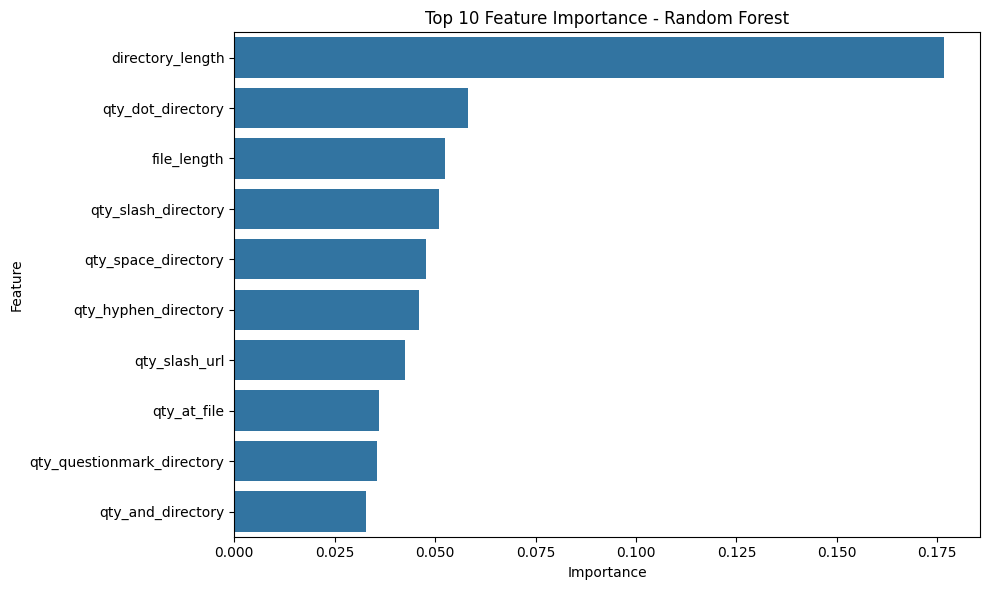


Gradient Boosting Cross-validation scores:
F1 Score: 0.862 (+/- 0.005)
Accuracy: 0.903 (+/- 0.004)
Precision: 0.859 (+/- 0.008)
Recall: 0.864 (+/- 0.008)


<Figure size 800x600 with 0 Axes>

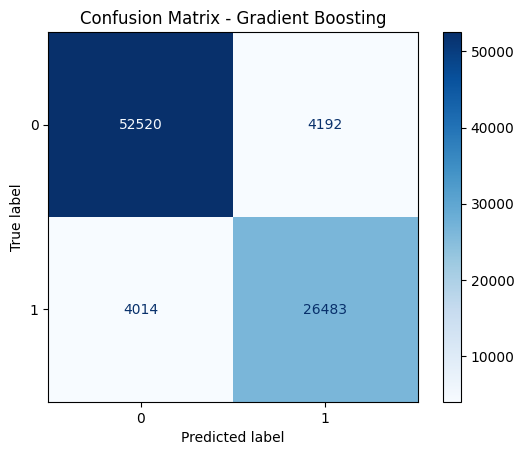

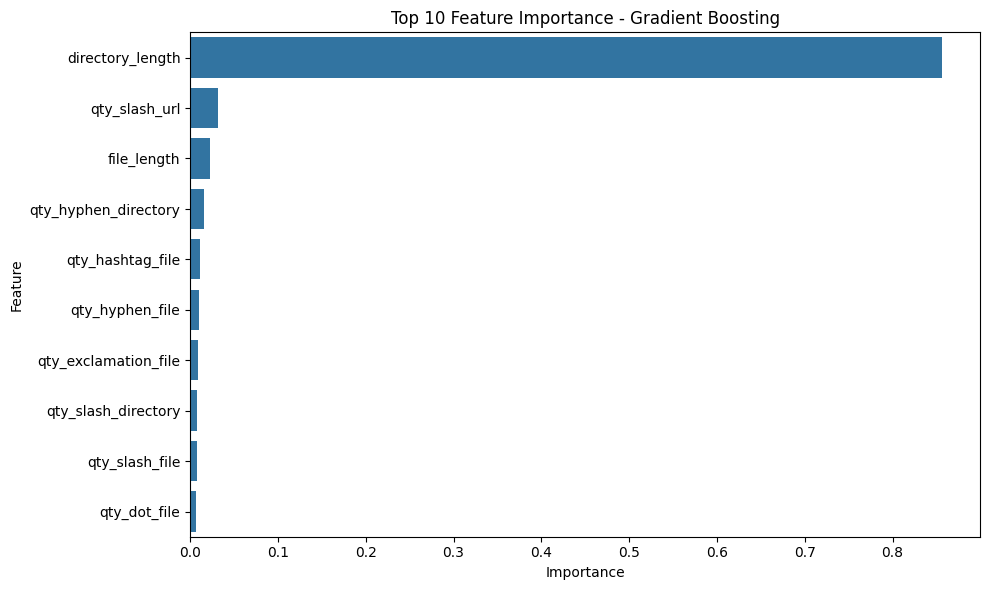


KNN Cross-validation scores:
F1 Score: 0.841 (+/- 0.021)
Accuracy: 0.886 (+/- 0.031)
Precision: 0.829 (+/- 0.127)
Recall: 0.863 (+/- 0.103)


<Figure size 800x600 with 0 Axes>

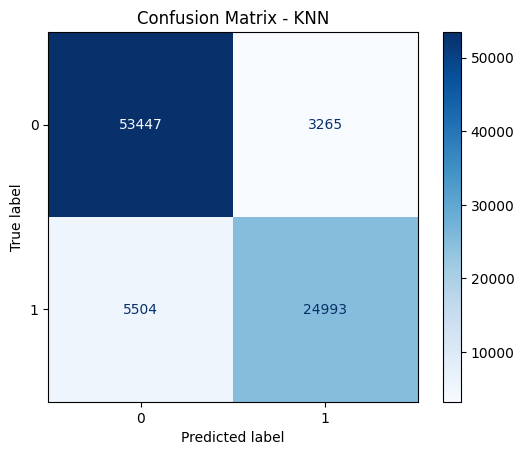


Naive Bayes Cross-validation scores:
F1 Score: 0.833 (+/- 0.007)
Accuracy: 0.864 (+/- 0.006)
Precision: 0.728 (+/- 0.009)
Recall: 0.975 (+/- 0.005)


<Figure size 800x600 with 0 Axes>

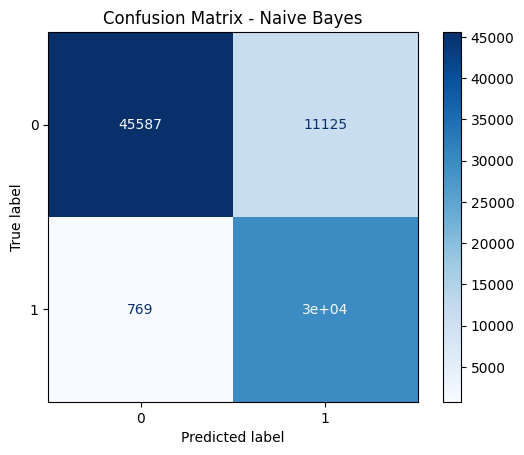

In [12]:
def evaluate_model(model, X, y, model_name):
    f1_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    accuracy_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    precision_scores = cross_val_score(model, X, y, cv=5, scoring='precision')
    recall_scores = cross_val_score(model, X, y, cv=5, scoring='recall')

    print(f"\n{model_name} Cross-validation scores:")
    print(f"F1 Score: {f1_scores.mean():.3f} (+/- {f1_scores.std() * 2:.3f})")
    print(f"Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std() * 2:.3f})")
    print(f"Precision: {precision_scores.mean():.3f} (+/- {precision_scores.std() * 2:.3f})")
    print(f"Recall: {recall_scores.mean():.3f} (+/- {recall_scores.std() * 2:.3f})")

    model.fit(X, y)
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    if hasattr(model, 'feature_importances_'):
        importances = pd.DataFrame({
            'feature': X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])],
            'importance': model.feature_importances_
        })
        importances = importances.sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=importances.head(10), x='importance', y='feature')
        plt.title(f'Top 10 Feature Importance - {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

models = {
    'Random Forest': rf_classifier,
    'Gradient Boosting': gb_classifier,
    'KNN': knn_classifier,
    'Naive Bayes': nb_classifier
}

for name, model in models.items():
    evaluate_model(model, X, y, name)